https://drive.google.com/open?id=0B-zGzdkbH440aDh1ckN4SWJlQ2ozeGM2cTNWN0lEY2R6NVhN

In [169]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
%matplotlib inline

from concurrent.futures import ProcessPoolExecutor

In [170]:
from sklearn.model_selection import train_test_split, cross_validate, validation_curve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

In [171]:
m1 = 1000
m2 = 10000
n = 20

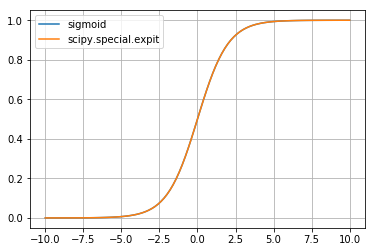

In [172]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

x = np.linspace(-10, 10, 101)
plt.plot(x, sigmoid(x), label="sigmoid")
plt.plot(x, expit(x), label="scipy.special.expit")
plt.legend()
plt.grid()

### Ia. ROC curve and AUC (practical)

In [122]:
# sample data
X1 = np.random.randn(m1, n)
X2 = np.random.randn(m2, n)
# sample true parameters of underlying model from N(0, 0.1^2)
w  = 0.1 * np.random.randn(n)
# generate labels for training and testing
p1 = sigmoid(np.dot(X1, w))
p2 = sigmoid(np.dot(X2, w))
y1 = np.random.binomial(1, p1)
y2 = np.random.binomial(1, p2)

(array([3., 2., 1., 2., 2., 2., 2., 2., 2., 2.]),
 array([0.03922077, 0.04141014, 0.0435995 , 0.04578886, 0.04797823,
        0.05016759, 0.05235695, 0.05454632, 0.05673568, 0.05892504,
        0.0611144 ]),
 <a list of 10 Patch objects>)

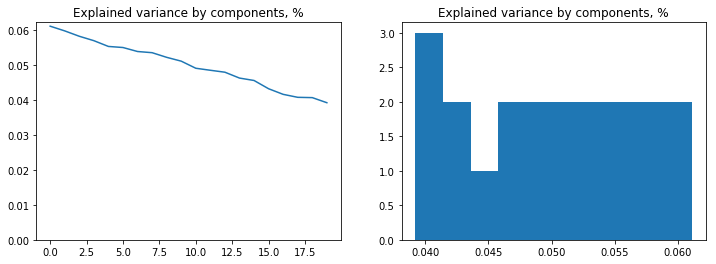

In [123]:
pca = PCA()
pca.fit(X1)
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(1, 2, 1, title="Explained variance by components, %")
ax.plot(pca.explained_variance_ratio_)
ax.set_ylim(bottom=0)
ax = f.add_subplot(1, 2, 2, title="Explained variance by components, %")
ax.hist(pca.explained_variance_ratio_)
#sns.kdeplot(pca.explained_variance_ratio_, ax=ax, kernel='cos')



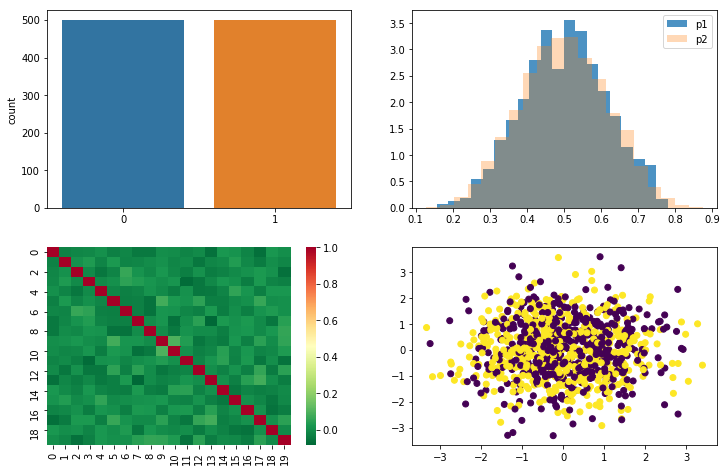

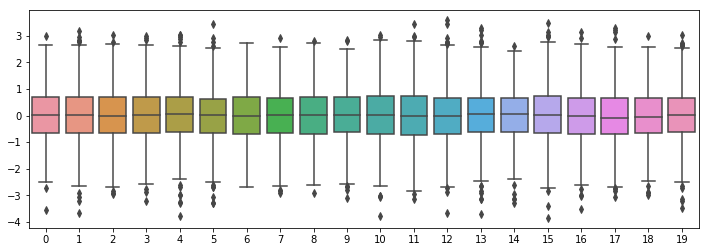

In [9]:
f = plt.figure(figsize=(12,8))
axs = f.subplots(2, 2)
sns.countplot(y1, ax=axs[0, 0])
#ax.hist()
#sns.kdeplot()
axs[0, 1].hist(p1, alpha=0.8, bins=20, label="p1", density=True)
axs[0, 1].hist(p2, alpha=0.3, bins=20, label="p2", density=True)
axs[0, 1].legend()
sns.heatmap(np.corrcoef(X1.T), cmap='RdYlGn_r', ax=axs[1,0])
_X = pca.transform(X1)[:, :2]
axs[1, 1].scatter(_X[:, 0], _X[:, 1], c=y1)
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(1,1,1)
sns.boxplot(data=X1, )
#_ = ax.boxplot(X1)


In [124]:
# 5. Split learning sample into 2 of size 800 and 200;
X_train, X_validate, y_train, y_validate = train_test_split(X1, y1, train_size=800)

In [125]:
from scipy import interp

def align_roc_curve(fpr, tpr, grid=100):
    if isinstance(grid, int):
        fpr_aligned = np.linspace(0, 1, grid+1)
    else:
        fpr_aligned = grid    
    tpr_aligned = interp(fpr_aligned, fpr, tpr)
    tpr_aligned[0] = 0.
    return fpr_aligned, tpr_aligned

In [141]:
   def compute_roc_auc(clf, C, X, y, n_iterations=100):
    """
    Compute `n_iterations` of aligned ROC curve
    """
    clf = clf.set_params(C=C)
    print "regularization: %.e" % clf.C
#    np.random.seed(seed=0)
    fpr_aligned = np.linspace(0, 1, 101)
    tprs = list()
    aucs = list()
    aucs_train = list()
    accuracies = list()
    accuracies_train = list()
    coefs = list()
    for _ in range(n_iterations):
        X_train, X_validate, y_train, y_validate_true = train_test_split(X, y, train_size=0.8)
        clf.fit(X_train, y_train)
        y_validate_score = clf.decision_function(X_validate)
        y_validate_predicted = clf.predict(X_validate)
        fpr, tpr, thresholds = roc_curve(y_validate_true, y_validate_score)
        _, tpr_aligned = align_roc_curve(fpr, tpr, grid=fpr_aligned)
        tprs.append(tpr_aligned)
        aucs.append(auc(fpr, tpr))
        aucs_train.append(roc_auc_score(y_train, clf.decision_function(X_train)))
        accuracies.append(accuracy_score(y_validate_true, y_validate_predicted))
        accuracies_train.append(accuracy_score(y_train, clf.predict(X_train)))
        coefs.append(clf.coef_.ravel())

    result = dict(
        C = C,
        tprs = np.array(tprs),
        aucs = np.array(aucs),
        aucs_train = np.array(aucs_train),
        accuracies = np.array(accuracies),
        accuracies_train = np.array(accuracies_train),
        coefs = np.array(coefs)
    )
    return result

clf = SVC(kernel='linear', C=1.)
#clf = LogisticRegression(penalty='l1', C=1.)
#clf = LogisticRegression(penalty='l1', C=1.)

from collections import OrderedDict
result = OrderedDict()
for i, C in enumerate(np.logspace(-5, 1, 7)):
    result[C] = compute_roc_auc(clf, C, X1, y1, n_iterations=100)
   

regularization: 1e-05
regularization: 1e-04


KeyboardInterrupt: 

          C  accuracy_mean  accuracy_std  accuracy_train_mean  \
0   0.00001        0.47815      0.029006             0.510925   
1   0.00010        0.47825      0.023774             0.507362   
2   0.00100        0.48995      0.037964             0.522038   
3   0.01000        0.58275      0.033162             0.623012   
4   0.10000        0.58440      0.031853             0.624038   
5   1.00000        0.58805      0.035601             0.625100   
6  10.00000        0.58285      0.030243             0.624450   

   accuracy_train_std  auc_mean   auc_std  auc_train_mean  auc_train_std  
0            0.022546  0.623617  0.034731        0.665306       0.009419  
1            0.010524  0.616906  0.033887        0.666775       0.008770  
2            0.028189  0.615075  0.036758        0.667881       0.009033  
3            0.010052  0.618582  0.036043        0.668340       0.009207  
4            0.011492  0.620736  0.035638        0.667175       0.009310  
5            0.010285  0.6220

Text(0.5,1,u'coefficients')

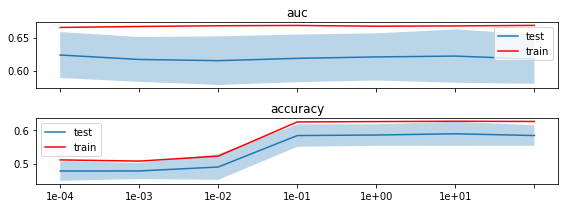

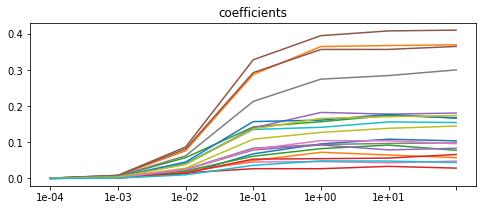

In [135]:
data = []
for rec in result.values():
    line = dict(
        C = rec['C'],
        auc_mean = rec["aucs"].mean(0),
        auc_std = rec["aucs"].std(0),
        auc_train_mean = rec["aucs_train"].mean(0),
        auc_train_std = rec["aucs_train"].std(0),
        accuracy_mean = rec["accuracies"].mean(0),
        accuracy_std = rec["accuracies"].std(0),
        accuracy_train_mean = rec["accuracies_train"].mean(0),
        accuracy_train_std = rec["accuracies_train"].std(0),
    )
    data.append(line)

df = pd.DataFrame(data)
print df


f, axs = plt.subplots(2,1, figsize=(8,3), sharex=True)
for i, measure in enumerate(["auc", "accuracy"]):
    axs[i].plot(df["%s_mean" % measure], label="test")
    axs[i].fill_between(df.index, 
                        df["%s_mean" % measure] - df["%s_std" % measure], 
                        df["%s_mean" % measure] + df["%s_std" % measure], 
                        alpha=0.3)
    axs[i].plot(df["%s_train_mean" % measure], color='red', label="train")
    axs[i].set_title(measure)
    axs[i].set_xticklabels(map(lambda x: "%.e" % x, df["C"]))
    axs[i].legend(loc='best')
f.tight_layout()

f, ax = plt.subplots(1,1, figsize=(8,3), sharex=True)
coefs = []
for k, rec in sorted(result.items()):
    coef_mean = rec["coefs"].mean(0)
    coef_magnitude = np.median(np.abs(rec["coefs"]), 0)
    coefs.append(coef_magnitude)
coefs = np.array(coefs)
print coefs.shape
_ = ax.plot(coefs)
ax.set_xticklabels(map(lambda x: "%.e" % x, df["C"]))
ax.set_title("coefficients")

    
#magnitude_coefs = [rec["coef"] for rec in data]

In [157]:
clf.set_params(C=1e-5)

SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [158]:
X_train, X_validate, y_train, y_validate_true = train_test_split(X1, y1, train_size=0.8)
clf.fit(X_train, y_train)
y_validate_score = clf.decision_function(X_validate)
y_validate_predicted = clf.predict(X_validate)


{'boxes': [<matplotlib.lines.Line2D at 0x186e8400>],
 'caps': [<matplotlib.lines.Line2D at 0x1d5e5550>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d5e5940>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d5e52b0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x186e8390>,
  <matplotlib.lines.Line2D at 0x1d5e5a90>]}

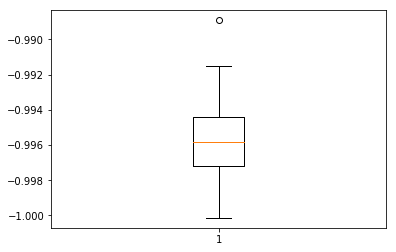

In [159]:
plt.boxplot(y_validate_score)

In [165]:
from scipy.stats import itemfreq
print Counter(y_validate_score > 0)
print itemfreq(y_validate_true)

print roc_auc_score(y_validate_true, y_validate_score)
print accuracy_score(y_validate_true, y_pred=y_validate_predicted)

Counter({False: 200})
[[  0  91]
 [  1 109]]
0.6051013206976509
0.455


In [168]:
109 / 200.

0.545

regularization: 1e-05
regularization: 1e-04
regularization: 1e-03
regularization: 1e-02
regularization: 1e-01
regularization: 1e+00
regularization: 1e+01
          C  auc.mean   auc.std
0   0.00001  0.615715  0.033724
1   0.00010  0.622097  0.032704
2   0.00100  0.621405  0.033487
3   0.01000  0.622948  0.033775
4   0.10000  0.623794  0.032792
5   1.00000  0.628109  0.033671
6  10.00000  0.619108  0.034141
(7L, 20L)


Text(0.5,1,u'Coefs')

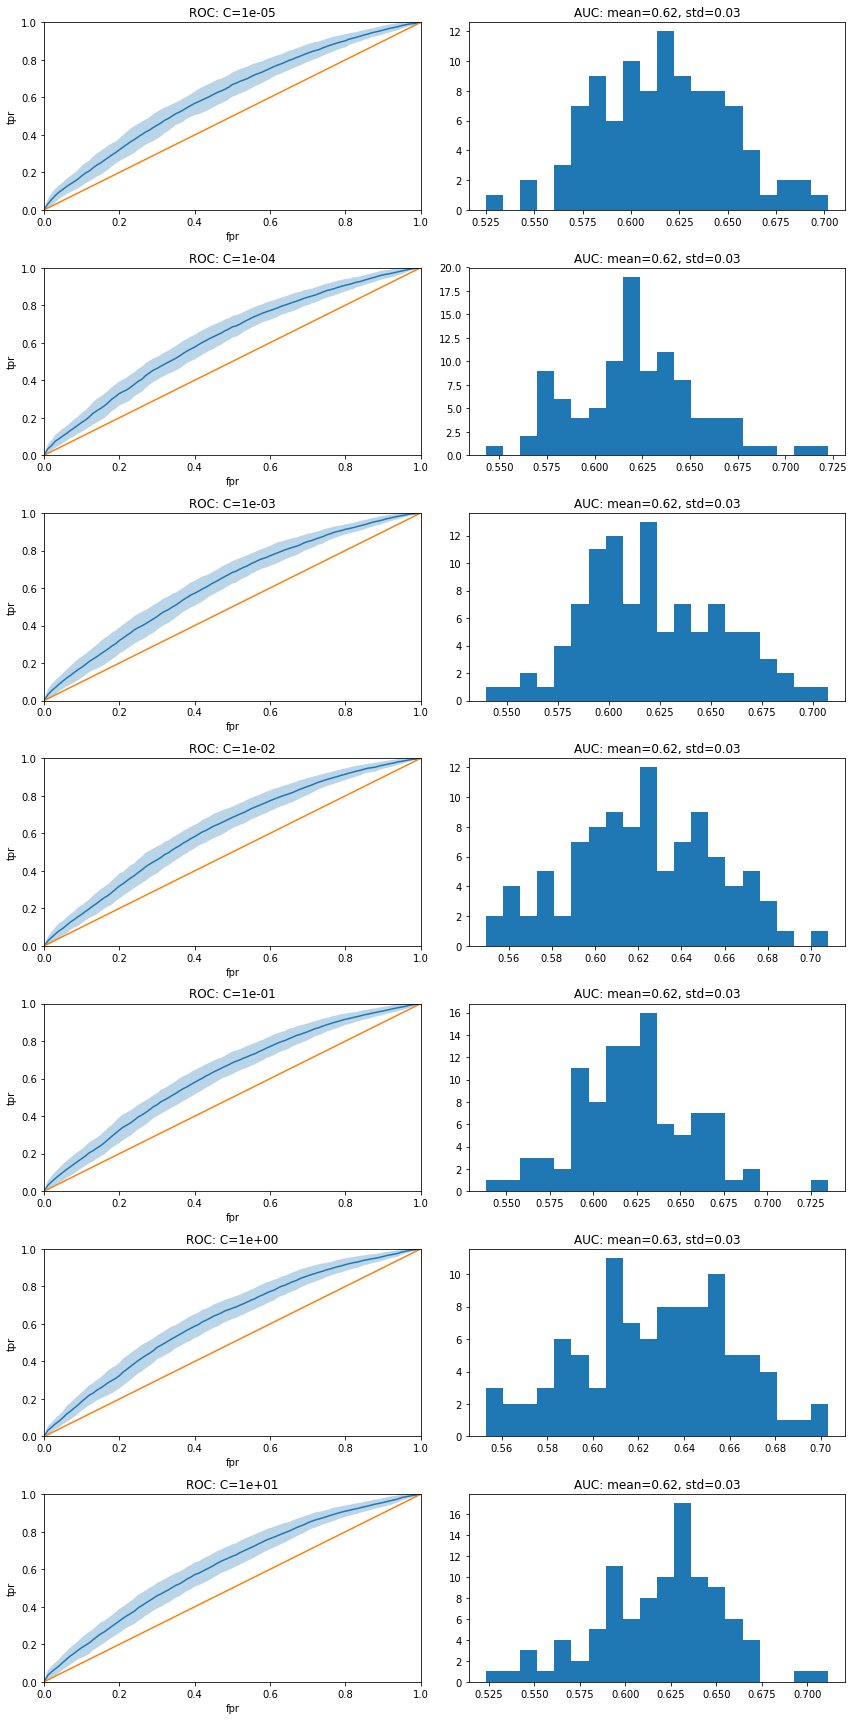

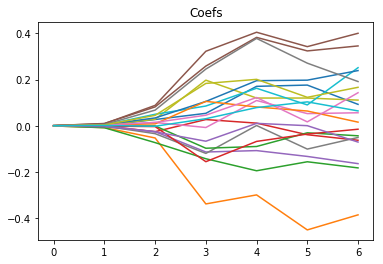

In [137]:
 
    
fpr_aligned = np.linspace(0, 1, 101)
f = plt.figure(figsize=(12,24))
axs = f.subplots(7, 2)

data = []
coefs = []
for i, C in enumerate(np.logspace(-5, 1, 7)):
    res = compute_roc_auc(clf, C, X1, y1, n_iterations=100)
    aucs = res['aucs']
    roc_mean = np.mean(res['tprs'], axis=0)
    roc_std = np.std(res['tprs'], axis=0)
    roc_upper = np.minimum(roc_mean + roc_std, 1.)
    roc_lower = np.maximum(roc_mean - roc_std, 0.)
    
    ax = axs[i, 0]
    ax.plot(fpr_aligned, roc_mean)
    ax.fill_between(fpr_aligned, roc_lower, roc_upper, alpha=0.3)
    ax.plot(fpr_aligned, fpr_aligned, label='clf_random')
    ax.set_title("ROC: C=%.e" % C)
    ax.set_xlim(0, 1)
    ax.set_ylim(0,1)
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")


    ax = axs[i, 1]
    ax.hist(aucs, bins=20)
    ax.set_title("AUC: mean=%.2f, std=%.2f" % (aucs.mean(), aucs.std()))
    data.append((C, aucs.mean(), aucs.std()))
    coefs.append(clf.coef_.ravel())
f.tight_layout()
df_auc = pd.DataFrame(data, columns=['C', 'auc.mean', 'auc.std'])
print df_auc
f = plt.figure()
ax = f.subplots()
coefs = np.array(coefs)
print coefs.shape
ax.plot(coefs)
ax.set_title("Coefs")

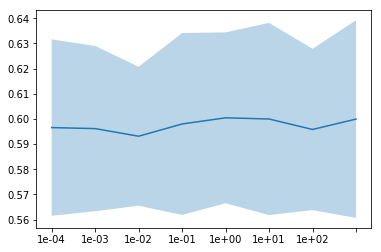

In [44]:
df_auc = pd.DataFrame(data, columns=['C', 'auc.mean', 'auc.std'])
f, ax = plt.subplots()
ax.plot(df_auc["auc.mean"])
ax.fill_between(np.arange(len(df_auc)), 
                 df_auc["auc.mean"] - df_auc["auc.std"], 
                 df_auc["auc.mean"] + df_auc["auc.std"],
                 alpha = 0.3,
                )
_ = ax.set_xticklabels(["%.e" % x for x in df_auc["C"]])

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', lw=lw)


In [59]:
clf = LogisticRegression( C=1.)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# 1b. ROC curve and AUC (semi-practical)

In [173]:
# sample data
X1 = np.random.randn(m1, n)
X2 = np.random.randn(m2, n)
# sample true parameters of underlying model from N(0, 0.1^2)
w  = 0.1 * np.random.randn(n)
# generate labels for training and testing
p1 = sigmoid(np.dot(X1, w))
p2 = sigmoid(np.dot(X2, w))
y1 = np.random.binomial(1, p1)
y2 = np.random.binomial(1, p2)

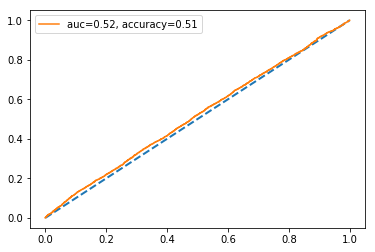

In [283]:
w0 = 0.1 * np.random.randn(n)     # noise estimate of w: p(w0|X, T) = p(w0) 
prob_predicted = sigmoid(np.dot(X2, w0))
y_predicted = prob_predicted > 0.5
fpr, tpr, thresholds = roc_curve(y2, prob_predicted)

f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(1,1,1)
ax.plot([0,1], lw=2, ls='--')
accuracy = accuracy_score(y2, y_predicted)
ax.plot(fpr, tpr, label="auc=%.2f, accuracy=%.2f" % (auc(fpr, tpr), accuracy))
ax.legend()


0.5003429628754963
0.027928477251715374


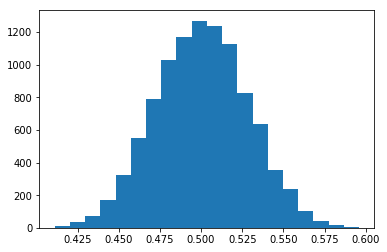

In [286]:
l_auc = []
for _ in range(10000):
    w0 = 0.1 * np.random.randn(n)     # noise estimate of w: p(w0|X, T) = p(w0) 
    prob_predicted = sigmoid(np.dot(X2, w0))
    l_auc.append(roc_auc_score(y2, prob_predicted))

plt.hist(l_auc, bins=20)
print np.mean(l_auc)
print np.std(l_auc)